In [1]:
# load dataset 
import pandas as pd 
from sklearn.model_selection import train_test_split
pathLyrics = 'lyrics-data.csv'
pathArtists = 'artists-data.csv'


dataframe = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

In [2]:
# filter Idiom for olny english lyrics
dataframe = dataframe[dataframe['Idiom'] == 'ENGLISH']

In [3]:
# normalize lycris to lowercase  
dataframe['Lyric'] = dataframe['Lyric'].apply(lambda lyric: lyric.lower())

# Zwei csv werden gemerged
mergeData=pd.merge(dataframe, dataframeArtists, how='inner', left_on='ALink', right_on='Link')

#Filtern der Daten. Nur Lyric und Genre für das Dataset notwendig
rawData= mergeData[['Lyric', 'Genre']]

# Speichern der csv zum Anschauen
# dataset.to_csv('dataset.csv') 

In [4]:
# Es werden die Spalten gefiltert, die Noten enthalten
rawData = rawData[~rawData['Lyric'].str.contains('----')] 

#Filtert alle Zeichen bis auf Buchstaben und Zahlen heraus
rawData['Lyric']=rawData['Lyric'].str.replace('[^a-zA-Z0-9]', ' ')


In [5]:
train, test = train_test_split(rawData, test_size=0.2)

#Zu Testzwecken kann man die große beschränken
#train = train.head(10)
#test = test.head(10)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

def vectorize_sequences (dataframe, dimensions=10000):
    vect = CountVectorizer()
    X = vect.fit_transform(dataframe)
    tokenizer = Tokenizer(num_words=dimensions)
    tokenizer.fit_on_texts(dataframe)
    sequences = tokenizer.texts_to_sequences(dataframe)
    one_hot_results = tokenizer.texts_to_matrix(dataframe, mode='binary')
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    return one_hot_results
    
def vectorize_labels(labels):
    return to_categorical(labels, 6)


In [12]:
X_train = vectorize_sequences(train['Lyric'])
y_train = vectorize_sequences(train['Genre'], 6) 

Found 107659 unique tokens.
Found 8 unique tokens.


In [34]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 6)                 102       
Total params: 160,390
Trainable params: 160,390
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

Train on 79310 samples, validate on 19828 samples
Epoch 1/50
79310/79310 [==============================] - 19s 233us/step - loss: 0.4107 - accuracy: 0.8034 - val_loss: 0.3613 - val_accuracy: 0.8147
Epoch 2/50
79310/79310 [==============================] - 25s 318us/step - loss: 0.3345 - accuracy: 0.8319 - val_loss: 0.3163 - val_accuracy: 0.8411
Epoch 3/50
79310/79310 [==============================] - 25s 316us/step - loss: 0.3046 - accuracy: 0.8446 - val_loss: 0.2992 - val_accuracy: 0.8461
Epoch 4/50
79310/79310 [==============================] - 30s 382us/step - loss: 0.2936 - accuracy: 0.8499 - val_loss: 0.2935 - val_accuracy: 0.8504
Epoch 5/50
79310/79310 [==============================] - 24s 304us/step - loss: 0.2887 - accuracy: 0.8531 - val_loss: 0.2896 - val_accuracy: 0.8531
Epoch 6/50
79310/79310 [==============================] - 25s 314us/step - loss: 0.2853 - accuracy: 0.8552 - val_loss: 0.2875 - val_accuracy: 0.8539
Epoch 7/50
79310/79310 [==============================] 

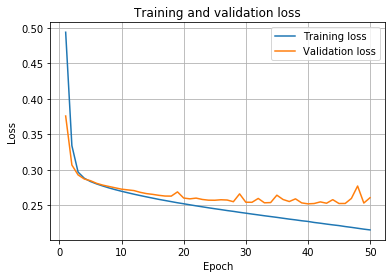

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
X_test = vectorize_sequences(test['Lyric'])
Y_test = vectorize_sequences(test['Genre'], 6) 


# compute loss and accuracy on test data
score = model.evaluate(X_test, Y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Found 59580 unique tokens.
Found 8 unique tokens.
24785/24785 [==============================] - 12s 487us/step
Test score: 0.46779534956705243
Test accuracy: 0.7715685963630676
